In [23]:
# Make boxes window width. 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time

In [3]:
class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(1,1,3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(1,1,3, padding=1, bias=False)
        
    def forward(self, x, t, net_params):
        self.conv1.weight = torch.nn.parameter.Parameter(net_params[0:9].view(1,1,3,3)) 
        self.conv2.weight = torch.nn.parameter.Parameter(net_params[9:18].view(1,1,3,3))
        self.conv1.weight
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [4]:
def RK4(f, x0, t0, t1, N,  net_params):
    h = (t1 - t0) / float(N) # calculate step size
    solution = [x0] # initialize saved dynamics
    t = t0
    for i in range(N):
        k1 = f(solution[i], t, net_params)
        k2 = f(solution[i] + h * k1 / 2.0, t + h/2.0, net_params)
        k3 = f(solution[i] + h * k2 / 2.0, t + h/2.0, net_params)
        k4 = f(solution[i] + h * k3, t + h, net_params)
        solution.append(solution[i] + h/6.0 * (k1 + k2 + k3 + k4))
        t = t + h  
    
    return solution

In [5]:
# dumb but will be replaced when ragged_tensor is a native pytorch feature
def tuple_add(*tuples):
    return tuple(sum(i) for i in zip(*tuples))
def tw(a, weight):
    return tuple(i * weight for i in a)

def RK4_backward(f, x0, t0, t1, N,  net_params):
    h = (t1 - t0) / float(N) # calculate step size
    solution = [x0] # initialize saved dynamics
    t = t0
    for i in range(N):
        k1 = f(solution[i], t, net_params)
        k2 = f(tuple_add(solution[i], tuple(h/2.0 * j for j in k1)), t + h/2.0, net_params)
        k3 = f(tuple_add(solution[i], tuple(h/2.0 * j for j in k2)), t + h/2.0, net_params)
        k4 = f(tuple_add(solution[i], tuple(h * j for j in k2)), t + h, net_params)
        solution.append(tuple_add(solution[i], tw(k1,h/6.0), tw(k2,h/6.0), tw(k3,h/6.0), tw(k4,h/6.0)))
                            
        t = t + h  
    
    return solution

In [6]:
class Integrate(torch.autograd.Function):
    def __deepcopy__(self, memo):
        return Integrate(copy.deepcopy(memo))
    
    @staticmethod
    def forward(ctx, Integrator, Integrator_backwards, f, x0, t0, t1, N, net_params):
        
        # Forward, Runge-Kutta 4th Order. 
        
        
        # Forward integration
        solution = Integrator(f, x0, t0, t1, N, net_params)
            
        # Save for jacobian calculations in backward()
        ctx.save_for_backward(x0,t0,t1)
        ctx.net_params = net_params
        ctx.solution = solution
        ctx.Integrator_backwards = Integrator_backwards
        ctx.N = N
        ctx.f = f
        
        return solution[-1]
    
    @staticmethod
    def backward(ctx, dL_dz1):
        
        # Get all saved context
        z0, t0, t1 = ctx.saved_tensors
        net_params = ctx.net_params
        dynamics = ctx.solution
        z1 = dynamics[-1]
        N = ctx.N
        f = ctx.f
        
        # Convenience sizes
        batch_size = z0.size()[0]
        img_size = z0.size()[3]
        img_len = img_size ** 2

        # Compute derivative w.r.t. to end time of integration
        dL_dt1 = dL_dz1.view(batch_size,1,-1).bmm(f(z1, t1, net_params).view(batch_size,-1,1))  # Derivative of loss w.r.t t1
        
        # Initial Condition
        s0 = (z1, dL_dz1, torch.zeros(net_params.size(), dtype=torch.float32), -dL_dt1) # initial augmented state
        
        # augmented dynamics function
        # what I really want is a Tensorflow Ragged Tensor, and pytorch's implementation really isn't there yet
        def aug_dynamics(s, t, theta):
            gradients = [torch.autograd.functional.vjp(f, 
                                                       (s[0][i,:,:].unsqueeze(0), t, theta), 
                                                       v=-s[1][i,:,:].unsqueeze(0)
                                                      )[1] for i in range(batch_size)]
            return (f(s[0],t,theta),
                    torch.cat([gradient[0] for gradient in gradients], dim=0), 
                    torch.cat([gradient[2].reshape(1,18) for gradient in gradients], dim=0), 
                    torch.cat([gradient[1].reshape(1,1) for gradient in gradients], dim=0),
                   )
        
        # Integrate backwards
        with torch.no_grad(): back_dynamics = ctx.Integrator_backwards(aug_dynamics, s0, t1, t0, N, net_params)
        
        # Extract derivatives
        _, dL_dz0, dL_dtheta, dL_dt0 = back_dynamics[-1]

        # must return something for every input to forward, None for non-tensors
        return None, None, None, dL_dz0, dL_dt0, dL_dt1, None, dL_dtheta 

In [7]:
class ODENet(nn.Module):
    def __init__(self, solver, solver_b, f, solver_params):
        super(ODENet, self).__init__()
        
        self.f = f()
        
        self.int_f = solver
        self.int_b = solver_b
        self.Integrate = Integrate()
        
        self.solver_params = solver_params
        self.N = solver_params["N"]
        self.h = (solver_params["t1"] - solver_params["t0"]) / solver_params["N"]
        self.t0 = torch.tensor(float(solver_params["t0"]), requires_grad=True)
        self.t1 = torch.tensor(float(solver_params["t1"]), requires_grad=True)
        self.net_params = torch.nn.parameter.Parameter(torch.Tensor(18).normal_(mean=0, std=0.1,generator=None), requires_grad=True)

        self.avg_pool = torch.nn.MaxPool2d(2, stride=2, padding=0)
        self.fc1 = nn.Linear(196, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = self.Integrate.apply(self.int_f, self.int_b, self.f, x, self.t0, self.t1, self.N, self.net_params) # Vanilla RK4
        x = self.avg_pool(x)
        x = x.view(-1, 196) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [8]:
def train(net, train_loader, test_loader, hyperparameters):
    
    lr = hyperparameters["lr"]
    n_epochs = hyperparameters["n_epochs"]
    momentum = hyperparameters["momentum"]
    
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    losses = []
    for i in range(n_epochs):
        
        # Train
        net.train()
        train_losses = []
        for j, (data, label) in enumerate(train_loader):
            
            optimizer.zero_grad()
            output = net(data)
            loss = F.nll_loss(output, label)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        """ Check ur gradients if the accuracy sucks
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(name, param.data, param.grad)
        """
        
        num_correct, test_losses = test(net, test_loader)
        losses.append([train_losses, test_losses])
        
        # Report
        print(
          "Avg Train Loss", sum(train_losses)/len(train_losses), "\n"
          "Avg Test Loss", sum(test_losses)/len(test_losses), "\n"
          "Test Accuracy", (num_correct / float(len(test_loader.dataset)) * 100).item(), "%"
         )
        print("----------------------------------------")
        
    return losses    

In [9]:
def test(net, test_loader):
    # Test
    net.eval()
    test_losses = []
    num_correct = 0
    with torch.no_grad():
        for j, (data, label) in enumerate(test_loader):

            output = net(data)
            loss = F.nll_loss(output, label)
            test_losses.append(loss.item())
            num_correct += label.eq(torch.max(output, 1, keepdim=False, out=None).indices).sum()

    
    return num_correct, test_losses 

In [10]:
batch_size_train = 64
batch_size_test = 1000
img_size = 28
img_len = 784

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/louis/Desktop/neuralODE/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/louis/Desktop/neuralODE/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [11]:
hyperparameters = {
    "lr":  0.01,
    "n_epochs": 1,
    "momentum": 0.5,
}

solver_params = {
    "t0": 0,
    "t1": 3,
    "N": 2,
}

In [12]:
TestNetwork = ODENet(RK4, RK4_backward, Block, solver_params)
losses = train(TestNetwork, train_loader, test_loader, hyperparameters)
torch.save(TestNetwork.state_dict(), "test.pth")

Avg Train Loss 0.5919227374038463 
Avg Test Loss 0.3258522868156433 
Test Accuracy 90.52000427246094 %
----------------------------------------


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

TestNetwork = ODENet(RK4, RK4_backward, Block, solver_params)
TestNetwork.load_state_dict(torch.load("test.pth"))
print("ODENet", count_parameters(TestNetwork), "parameters")
print(TestNetwork)
print(TestNetwork.solver_params)

ODENet 10396 parameters
ODENet(
  (f): Block(
    (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (avg_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=196, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
{'t0': 0, 't1': 3, 'N': 2}


In [16]:
from memtorch.mn.Module import patch_model
from memtorch.map.Parameter import naive_map
from memtorch.bh.crossbar.Program import naive_program
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities
import memtorch
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

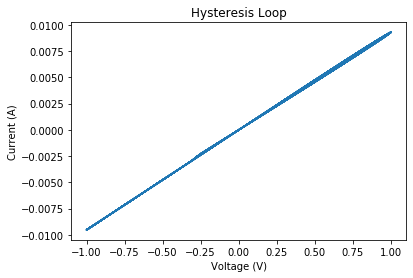

In [17]:
reference_memristor = memtorch.bh.memristor.VTEAM
reference_memristor_params = {'time_series_resolution': 1e-10, 
                              'r_off': memtorch.bh.StochasticParameter(200, std=20, min=2),
                              'r_on': memtorch.bh.StochasticParameter(100, std=10, min=1)}
memristor = reference_memristor(**reference_memristor_params)
memristor.plot_hysteresis_loop()

Stochastic Weights

Patched Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) -> bh.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=(1,1), padding=(1,1))
Patched Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) -> bh.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=(1,1), padding=(1,1))
Patched Linear(in_features=196, out_features=50, bias=True) -> bh.Linear(in_features=196, out_features=50, bias=True)
Patched Linear(in_features=50, out_features=10, bias=True) -> bh.Linear(in_features=50, out_features=10, bias=True)
Tuned bh.Linear(in_features=196, out_features=50, bias=True). Coefficient of determination: 0.760558 [40.682610, -0.000321]
Tuned bh.Linear(in_features=50, out_features=10, bias=True). Coefficient of determination: 0.981813 [96.758583, 0.000752]
Tuned bh.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=(1,1), padding=(1,1)). Coefficient of determination: 1.000000 [30.392128, -0.000000]
Tuned b

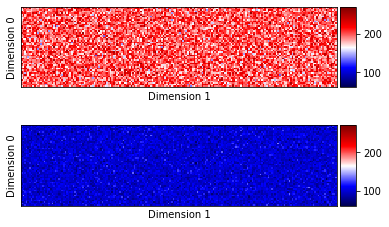

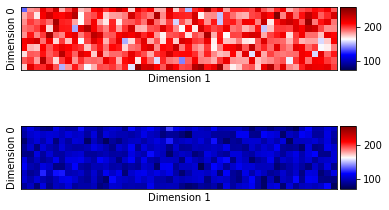

In [37]:
patched_model = patch_model(copy.deepcopy(TestNetwork),
                          memristor_model=reference_memristor,
                          memristor_model_params=reference_memristor_params,
                          module_parameters_to_patch=[torch.nn.Linear, torch.nn.Conv2d],
                          mapping_routine=naive_map,
                          transistor=True,
                          programming_routine=None)


patched_model.tune_()

print("--------")
print("Accuracy:", (test(patched_model, test_loader)[0] / float(len(test_loader.dataset))).item())
print("--------")


def plot(A,B,C,filename):
    plt.subplot(2, 1, 1)
    plt.imshow(A.transpose(0, 1), interpolation='nearest', aspect=1, vmin=C.min(), vmax=C.max(), cmap='seismic')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 0')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)

    plt.subplot(2, 1, 2)
    plt.imshow(B.transpose(0, 1), interpolation='nearest', aspect=1, vmin=C.min(), vmax=C.max(), cmap='seismic')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 0')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.savefig(filename, dpi=1000)
    plt.show()

A = torch.Tensor(np.vectorize(lambda x: x.r_off)(patched_model.fc1.crossbars[0].devices))
B = torch.Tensor(np.vectorize(lambda x: x.r_on)(patched_model.fc1.crossbars[0].devices))
C = torch.cat((A, B), 0)

plot(A,B,C,'fig1.png')

A = torch.Tensor(np.vectorize(lambda x: x.r_off)(patched_model.fc2.crossbars[0].devices))
B = torch.Tensor(np.vectorize(lambda x: x.r_on)(patched_model.fc2.crossbars[0].devices))
C = torch.cat((A, B), 0)

plot(A,B,C,'fig2.png')

Finite Conductance States

--------
Accuracy: 0.8129000067710876
--------


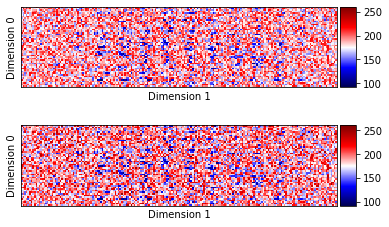

torch.Size([50, 10])
tensor([102.9843, 103.6276, 103.7394, 105.5184, 106.0665, 108.7732, 109.3332,
        109.5392, 110.4559, 111.4637, 111.6079, 113.0281, 113.0551, 113.2767,
        113.4157, 114.3246, 114.9663, 115.3081, 115.7146, 115.7962, 115.8568,
        116.6202, 117.3441, 118.0974, 118.3601, 118.4909, 118.5818, 118.7601,
        118.8214, 119.0359, 119.0950, 119.0957, 119.1678, 119.2415, 119.3679,
        121.5799, 121.8349, 123.0895, 123.4388, 123.7841, 124.0614, 124.2132,
        125.4102, 125.4522, 125.5008, 126.0005, 126.0055, 126.0616, 126.1314,
        126.1405, 126.2224, 126.2322, 126.5044, 126.7259, 127.1508, 127.2290,
        127.2914, 127.4129, 127.4152, 127.4174, 127.6310, 127.7355, 127.8464,
        127.8972, 128.2082, 128.7258, 129.7746, 130.5561, 131.2529, 131.3060,
        131.4778, 131.7673, 131.9171, 132.5658, 132.8361, 132.8694, 132.9653,
        134.0606, 134.1624, 134.2703, 134.4151, 135.1531, 135.4777, 135.5063,
        135.6376, 135.9169, 136.2279, 136.4

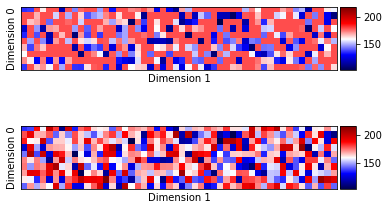

In [45]:
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities

A = 1 / patched_model.fc1.crossbars[0].conductance_matrix
model = apply_nonidealities(copy.deepcopy(patched_model),
                                  non_idealities=[memtorch.bh.nonideality.NonIdeality.FiniteConductanceStates],
                                  conductance_states = 5)

print("--------")
print("Accuracy:", (test(model, test_loader)[0] / float(len(test_loader.dataset))).item())
print("--------")

B = 1 / model.fc1.crossbars[0].conductance_matrix
C = torch.cat((A, B), 0)

plot(A,B,C,'fig3.png')

A = 1 / patched_model.fc2.crossbars[0].conductance_matrix
model = apply_nonidealities(copy.deepcopy(patched_model),
                                  non_idealities=[memtorch.bh.nonideality.NonIdeality.FiniteConductanceStates],
                                  conductance_states = 5)

B = 1 / model.fc2.crossbars[0].conductance_matrix
print(B.size())
print(B.unique())
print(B.unique().size())
#print(A[0])
#print(B[0])
C = torch.cat((A, B), 0)

plot(A,B,C,'fig4.png')

Device Faults

--------
Accuracy: 0.2565000057220459
--------


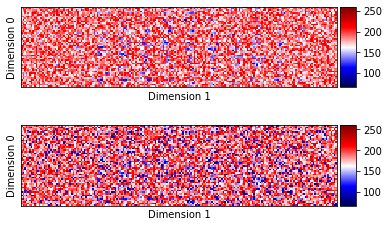

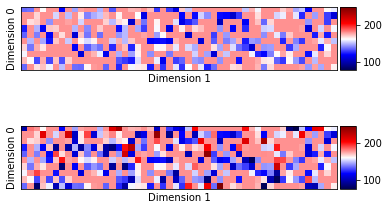

In [46]:
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities


A = 1 / patched_model.fc1.crossbars[0].conductance_matrix
model = apply_nonidealities(copy.deepcopy(patched_model),
                                  non_idealities=[memtorch.bh.nonideality.NonIdeality.DeviceFaults],
                                  lrs_proportion=0.1,
                                  hrs_proportion=0.1,
                                  electroform_proportion=0)
B = 1 / model.fc1.crossbars[0].conductance_matrix





C = torch.cat((A, B), 0)

print("--------")
print("Accuracy:", (test(model, test_loader)[0] / float(len(test_loader.dataset))).item())
print("--------")

plot(A,B,C,'fig5.png')

A = 1 / patched_model.fc2.crossbars[0].conductance_matrix
B = 1 / model.fc2.crossbars[0].conductance_matrix
C = torch.cat((A, B), 0)

plot(A,B,C,'fig6.png')